# Obtaining obstacle-free convex regions from lidar data

In [1]:
import copy
import cvxpy as cp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

## Load and visualize data

In [2]:
cwd = os.getcwd()
data_folder = cwd + os.sep + 'data' + os.sep

def load_scan_data(data_file: str):
    scan_data = np.loadtxt(data_file, delimiter=',')
    angles = scan_data[:, 0]
    ranges = scan_data[:, 1]
    return angles, ranges
    
def load_odom_data(pos_file: str):
    pose = np.loadtxt(pos_file, delimiter=',')
    ego_pos = pose[:2]
    ego_yaw = pose[2]
    return ego_pos, ego_yaw
    
head_angles, head_ranges = load_scan_data(data_folder + 'ego_scan.csv')
trail_angles, trail_ranges = load_scan_data(data_folder + 'opp_scan.csv')

head_pos, head_yaw = load_odom_data(data_folder + 'ego_pose.csv')
trail_pos, trail_yaw = load_odom_data(data_folder + 'opp_pose.csv')

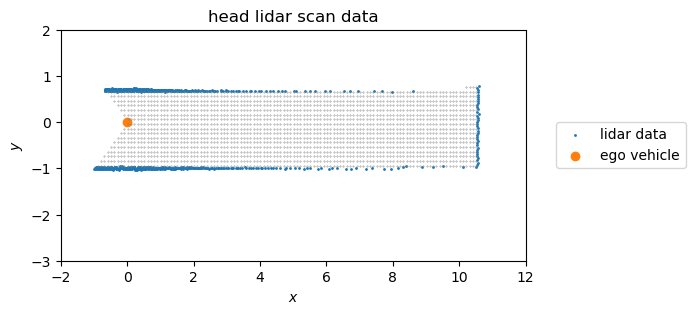

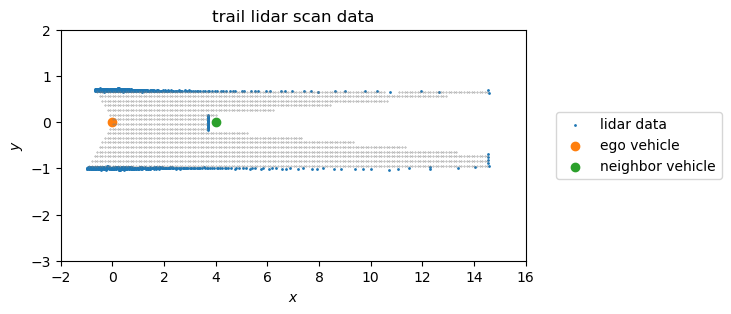

In [3]:
def plot_scan(angles, ranges, title: str, neighbor_rel_pos = np.array([0, 0])):
    x = ranges * np.cos(angles)
    y = ranges * np.sin(angles)
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)
    
    plt.figure(figsize=(6, 3))
    plt.scatter(x, y, s=1, label='lidar data')
    plt.scatter(0, 0, label='ego vehicle')
    if (neighbor_rel_pos != 0.).any():
        plt.scatter(neighbor_rel_pos[0], neighbor_rel_pos[1], label='neighbor vehicle')
    plt.title(title)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.xlim([np.floor(x_min) - 1, np.ceil(x_max) + 1])
    plt.ylim([np.floor(y_min) - 1, np.ceil(y_max) + 1])
    plt.legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

def plot_points_in_path(path, x_min, x_max, y_min, y_max):
    for x in np.arange(x_min, x_max, 0.1):
        for y in np.arange(y_min, y_max, 0.1):
            if path.contains_point(np.array([x, y])):
                plt.scatter(x, y, s=0.1, color='gray')

# visualize points within the lidar scan

head_x = head_ranges * np.cos(head_angles)
head_x_min, head_x_max = np.min(head_x), np.max(head_x)
head_y = head_ranges * np.sin(head_angles)
head_y_min, head_y_max = np.min(head_y), np.max(head_y)
head_pc = np.c_[head_x, head_y]

plot_scan(head_angles, head_ranges, 'head lidar scan data')
head_path = matplotlib.path.Path(np.r_[np.array([[0, 0]]), head_pc, np.array([[0, 0]])])
plot_points_in_path(head_path, head_x_min, head_x_max, head_y_min, head_y_max)

trail_x = trail_ranges * np.cos(trail_angles)
trail_x_min, trail_x_max = np.min(trail_x), np.max(trail_x)
trail_y = trail_ranges * np.sin(trail_angles)
trail_y_min, trail_y_max = np.min(trail_y), np.max(trail_y)
trail_pc = np.c_[trail_x, trail_y]

plot_scan(trail_angles, trail_ranges, 'trail lidar scan data', neighbor_rel_pos = head_pos - trail_pos)
trail_path = matplotlib.path.Path(np.r_[np.array([[0, 0]]), trail_pc, np.array([[0, 0]])])
plot_points_in_path(trail_path, trail_x_min, trail_x_max, trail_y_min, trail_y_max)

## Components of IRIS algorithm for lidar point cloud data

### Step 0: find closest point in point cloud

In [4]:
def closest_point_in_cloud(V, C, d, C_inv = np.zeros((2, 2))):
    """
    Computes the closest lidar point to the ellipse described by a positive 
    semidefinite matrix and the ellipse center.

    Args:
        V (list): Set of adjacent vertices
        C (np.ndarray): Shape (2, 2), positive semidefinite, describes ellipse 
            of form {Cx + d | \|x\| <= 1}
        d (np.ndarray): Shape (2,), center of the ellipse
        C_inv (np.ndarray): Shape (2, 2), optional, inverse of C. If default 
            value is used, we will compute C_inv in the function
    
    Returns:
        int: Index of closest point in point cloud
    """
    pc = np.array([V[i][0] for i in range(len(V))])
    if (C_inv == 0.0).all():
        C_inv = np.linalg.inv(C)
    pc_tilde = (pc - d) @ C_inv
    dists = np.linalg.norm(pc_tilde, axis=1)
    return np.argmin(dists)

### Step 1: find closest point on line segment containing two adjacent points

In [5]:
def closest_point_between_points(p1, p2, C, d, C_inv = np.zeros((2, 2))):
    """
    Computes the point on the line segment between two points that is closest 
    to an ellipse.

    Args:
        p1 (np.ndarray): Shape (2,), first point
        p2 (np.ndarray): Shape (2,), second point
        C (np.ndarray): Shape (2, 2), positive semidefinite, describes ellipse 
            of form {Cx + d | \|x\| <= 1}
        d (np.ndarray): Shape (2,), center of the ellipse
        C_inv (np.ndarray): Shape (2, 2), optional, inverse of C. If default 
            value is used, we will compute C_inv in the function
    
    Returns:
        np.ndarray: Shape (2,), 2D coordinate of the closest point on the 
            line segment to the ellipse
        float: Distance from the center of the ellipsoid to the point 
            (in the ellipsoidal metric)
    """
    if (C_inv == 0.0).all():
        C_inv = np.linalg.inv(C)
    p1_tilde = C_inv @ (p1 - d)
    p2_tilde = C_inv @ (p2 - d)

    # construct QP
    x_tilde = cp.Variable(2)  # dimension of state space
    w = cp.Variable(2)  # number of vertices
    objective = cp.Minimize(cp.sum_squares(x_tilde))
    constraints = [np.c_[p1_tilde, p2_tilde] @ w == x_tilde,
                   cp.sum(w) == 1,
                   w >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    x_star = C @ x_tilde.value + d
    dist = np.linalg.norm(x_star - d)
    return x_star, dist

### Step 2: find tangent plane

In [6]:
def tangent_plane(C, d, x, C_inv = np.zeros((2, 2))):
    """
    Finds the plane tangent to the ellipse at the point given by x, i.e.,
    the plane a^T x = b such that a is normal to the surface of the 
    ellipsoid given by {Cx + d | \|x\| <= 1}.

    Args:
        C (np.ndarray): Shape (2, 2), positive semidefinite, describes ellipse 
            of form {Cx + d | \|x\| <= 1}
        d (np.ndarray): Shape (2,), center of the ellipse
        x (np.ndarray): Shape (2,), point of interest
        C_inv (np.ndarray): Shape (2, 2), optional, inverse of C. If default 
            value is used, we will compute C_inv in the function
    
    Returns:
        np.ndarray: Shape (2,), vector normal to the plan
        float: plane offset
    """
    if (C_inv == np.zeros((2, 2))).all():
        C_inv = np.linalg.inv(C)
    a = 2 * C_inv @ C_inv.T @ (x - d)
    b = a @ x
    norm_a = np.linalg.norm(a)
    return a / norm_a, b / norm_a

### Step 3: remove redundant vertices

In [7]:
def remove_redundant_vertices(V, a, b):
    """
    Removes pairs of vertices from V if both points in the pair satisfy 
    a^T p >= b.T

    Args:
        V (list): Set of adjacent vertices
        a (np.ndarray): Shape (2,), normal to halfspace
        b (float): Offset for halfspace
    
    Returns:
        list: V with points removed
    """
    start = len(V)
    for i, (p1, p2) in enumerate(V):
        if a @ p1 >= b and a @ p2 >= b:
            del V[i]
    end = len(V)
    print(f"start length: {start}, end_length: {end}")
    return V

### Step 4: Compute the inscribed ellipsoid

#### Using Mosek

In [8]:
# def det_rootn(M, t, n):
#     # Setup variables
#     Y = M.variable(mosek.fusion.Domain.inPSDCone(2 * n))

#     # Setup Y = [X, Z; Z^T , diag(Z)]
#     X   = Y.slice([0, 0], [n, n])
#     Z   = Y.slice([0, n], [n, 2 * n])
#     DZ  = Y.slice([n, n], [2 * n, 2 * n])

#     # Z is lower-triangular
#     M.constraint(Z.pick([[i,j] for i in range(n) for j in range(i+1,n)]), mosek.fusion.Domain.equalsTo(0.0))
#     # DZ = Diag(Z)
#     M.constraint(mosek.fusion.Expr.sub(DZ, mosek.fusion.Expr.mulElm(Z, mosek.fusion.Matrix.eye(n))), mosek.fusion.Domain.equalsTo(0.0))

#     # (Z11*Z22*...*Znn) >= t^n
#     M.constraint(mosek.fusion.Expr.vstack(DZ.diag(), t), mosek.fusion.Domain.inPGeoMeanCone())

#     # Return an n x n PSD variable which satisfies t <= det(X)^(1/n)
#     return X

# def inscribed_ellipsoid_mosek(A, b):
#     """
#     Returns the of ellipsoid of maximum volume that is inscribed within the 
#     polyhedron given by Ax <= b. The ellipsoid is given by 
#     {Cx + d | \|x\| <= 1}

#     Args:
#         A (np.ndarray): Shape (m, 2), rows give normals to halfspaces
#         b (np.ndarray): Shape (m,), offset for halfspaces
    
#     Returns:
#         C (np.ndarray): Shape (2, 2), matrix defining ellipsoid scaling
#         d (np.ndarray): Shape (2,), array describing ellipsoid center
#     """
#     with mosek.fusion.Model("lownerjohn_inner") as M:
#         M.setLogHandler(sys.stdout)
#         m, n = len(A), len(A[0])

#         # Setup variables
#         t = M.variable("t", 1, mosek.fusion.Domain.greaterThan(0.0))
#         C = det_rootn(M, t, n)
#         d = M.variable("d", n, mosek.fusion.Domain.unbounded())

#         # (b-Ad, AC) generate cones
#         M.constraint("qc", mosek.fusion.Expr.hstack(mosek.fusion.Expr.sub(b, mosek.fusion.Expr.mul(A, d)), mosek.fusion.Expr.mul(A, C)),
#                      mosek.fusion.Domain.inQCone())

#         # Objective: Maximize t
#         M.objective(mosek.fusion.ObjectiveSense.Maximize, t)

#         M.writeTask("lj-inner.ptf")
#         M.solve()

#         C, d = C.level(), d.level()
#         return ([C[i:i + n] for i in range(0, n * n, n)], d)

#### Using CVX

In [9]:
def inscribed_ellipsoid(A, b):
    """
    Returns the of ellipsoid of maximum volume that is inscribed within the 
    polyhedron given by Ax <= b. The ellipsoid is given by 
    {Cx + d | \|x\| <= 1}

    Args:
        A (np.ndarray): Shape (m, 2), rows give normals to halfspaces
        b (np.ndarray): Shape (m,), offset for halfspaces
    
    Returns:
        C (np.ndarray): Shape (2, 2), matrix defining ellipsoid scaling
        d (np.ndarray): Shape (2,), array describing ellipsoid center
    """
    C = cp.Variable((2, 2))
    d = cp.Variable(2)
    objective = cp.Maximize(cp.log_det(C))
    constraints = [cp.norm(C @ A[i, :]) + A[i, :] @ d <= b[i] for i in range(A.shape[0])]
    constraints += [C >> 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return C.value, d.value

## Putting it all together: the IRIS algorithm

In [10]:
def separating_hyperplanes(C, d, pc):
    """
    Algorithm to find hyperplanes that separate the ellipse from the point 
    cloud.
    """
    C_inv = np.linalg.inv(C)
    vertices_remaining = [[pc[i, :], pc[i+1, :]] for i in range(pc.shape[0] - 1)]
    a_list = []
    b_list = []

    while vertices_remaining:
        closest_ind = closest_point_in_cloud(vertices_remaining, C, d, C_inv)
        closest_vertices = [vertices_remaining[closest_ind]]
        if closest_ind > 0:
            closest_vertices.append(vertices_remaining[closest_ind - 1])
        for vertices in closest_vertices:
            x, dist = closest_point_between_points(vertices[0], vertices[1], C, d, C_inv)
            a, b = tangent_plane(C, d, x, C_inv)
            a_list.append(a)
            b_list.append(b)
            vertices_remaining = remove_redundant_vertices(vertices_remaining, a, b)
    
    return np.array(a_list), np.array(b_list)

def iris_algorithm(q0, eps, pc, tol, max_iters):
    """
    The IRIS algorithm: given a starting point, an initial size for a ball 
    around that point, and a 2D point cloud, find an obstacle free polyhedron 
    given by Ax <= b and an ellipsoid {Cx + d | \|x\| <= 1} such that the 
    ellipsoid is contained in the polyhedron and the polyhedron intersects 
    the obstacles only at their boundaries.

    Args:
        q0 (np.ndarray): Shape (2,), starting location of the ellipse
        eps (float): Size of initial ball/ellipse around q0
        pc (np.ndarray): Shape (L, 2), point cloud data
        tol (float): value to indicate stopping condition (if the ellipsoid 
            stops growing)
        max_iters (int): Maximum number of iterations we allow the algorithm to 
            run for
    
    Returns:
        A (np.ndarray): Shape (m, 2), matrix to describe polyhedron, rows give 
            the normals to the halfspaces
        b (np.ndarray): Shape (m,), offset for halfspaces
        C (np.ndarray): Shape (2, 2), matrix defining ellipsoid scaling
        d (np.ndarray): Shape (2,), array describing ellipsoid center
    """
    C = eps * np.eye(2)
    d = q0
    i = 0
    while i < max_iters:
        det_C = np.linalg.det(C)

        A, b = separating_hyperplanes(C, d, pc)
        new_C, d = inscribed_ellipsoid(A, b)

        det_new_C = np.linalg.det(new_C)
        if (det_new_C - det_C) / det_C < tol:
            return A, b, new_C, d
        C = copy.deepcopy(new_C)
    return A, b, C, d

In [11]:
# def test_vanilla():
#     # doesn't work, too slow!
#     q0 = np.array([0.5, 0.0])
#     eps = .01
#     tol = .1
#     max_iters = 10
#     A, b, C, d = iris_algorithm(q0, eps, head_pc, tol, max_iters)
#     print(A)
#     print(b)
#     print(C)
#     print(d)